## Imports 

In [20]:
import common.feature_string as feature_string
import common.feature_num as feature_num
import common.feature_categorica as feature_categorica
import common.common_machine_learning as common
import common.my_pipeline as my_pipe
import pandas as pd
import numpy as np
from hyperopt import fmin, tpe, hp, STATUS_OK
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import Pipeline
from xgboost import XGBRegressor
import xgboost as xgb
import time

#### Ignore Warnings 

In [2]:
from warnings import simplefilter
simplefilter(action='ignore', category=FutureWarning)

## Constantes 

In [3]:
TARGET = 'precio'
XGB_RE_OBJECTIVE = 'reg:squarederror'

## Cargar de sets de datos 

In [4]:
train = common.cargar_set_optimizado('sets_de_datos/train.csv', index_col = 0)
X_test = common.cargar_set_optimizado('sets_de_datos/test.csv', index_col = 0)

## Preparacion de features

El siguiente agregado de features puede tardar unos minutos.  
Dima's PC time = 3 minutos (aprox.)

In [5]:
t0 = time.time()
feature_num.agregar_feature_fecha_numerica(train)
train = feature_categorica.agregar_feature_one_hot_encoding(train)
feature_string.agregar_feature_todos_ref(train)
t1 = time.time()
print('Tiempo = {0:.2f} minutos'.format((t1-t0)/60))

Tiempo = 2.80


In [9]:
t0 = time.time()
feature_num.agregar_feature_fecha_numerica(X_test)
X_test = feature_categorica.agregar_feature_one_hot_encoding(X_test)
feature_string.agregar_feature_todos_ref(X_test)
t1 = time.time()
print('Tiempo = {0:.2f} minutos'.format((t1-t0)/60))

Tiempo = 0.66


In [6]:
feature_num.eliminar_num_no_feature(train)
feature_categorica.eliminar_categoria_no_feature(train)
feature_string.eliminar_string_no_feature(train)

In [10]:
feature_num.eliminar_num_no_feature(X_test)
feature_categorica.eliminar_categoria_no_feature(X_test)
feature_string.eliminar_string_no_feature(X_test)

## Split Muetras & Target 

In [11]:
X_train = train.drop([TARGET], axis = 1).copy()
y_train = train[TARGET].copy()

## Pipeline + Xgboost 

In [12]:
hyper_parametros = {
    'colsample_bytree': 0.6269206294878382, 
    'gamma': 0.3627342789120286, 
    'lambda': 1.1126608037893504, 
    'learning_rate': 0.011511019740908655, 
    'max_depth': 75, 
    'min_child_weight': 8, 
    'n_estimators': 528, 
    'subsample': 0.5914933850528934
}

xgb_model = XGBRegressor(
    objective = XGB_RE_OBJECTIVE,
    **hyper_parametros
)

pre_processor_pipe = my_pipe.get_columns_pipeline()

pipe = Pipeline(steps = [
    ('preprocessing', pre_processor_pipe), 
    ('xgb_regressor', xgb_model)
])

## Entrenamiento

In [16]:
t0 = time.time()
pipe = pipe.fit(X_train, y_train)
t1 = time.time()
print('Tiempo = {0:.2f} minutos'.format((t1-t0)/60))

Tiempo = 3.28 minutos


## Prediccion

In [17]:
y_pred = pipe.predict(X_test)

## Persistir resultados 

In [18]:
res = pd.DataFrame(y_pred, index=X_test.index, columns=['target'])
res.to_csv("submits/dima_submit_xgboost_2.csv", header=True)

## Feature Importance 

La siguiente operacion toma unos minutos

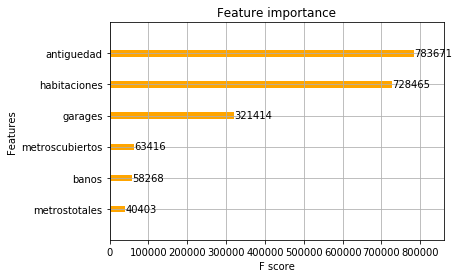

In [41]:
dtrain = xgb.DMatrix( X_train, label=y_train)
mapper = {'f{0}'.format(i): v for i, v in enumerate(dtrain.feature_names)}
mapped = {mapper[k]: v for k, v in xgb_model.get_booster().get_score().items()}
xgb.plot_importance(mapped, color='orange')